In [2]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
#x是特征，y是标签
x, y = datasets.make_moons(n_samples=50000, noise=0.3, random_state=42)
print(x.shape)
print(y.shape)
print(np.unique(y))

(50000, 2)
(50000,)
[0 1]


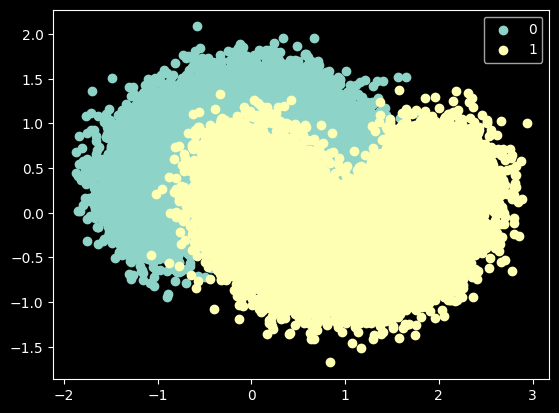

In [3]:
plt.scatter(x[y == 0, 0], x[y == 0, 1]) #拿到特征中标签为0的第0列，拿到标签为0的第一列
plt.scatter(x[y == 1, 0], x[y == 1, 1]) #拿到特征中标签为1的第0列，拿到标签为1的第一列
plt.legend(['0', '1'])
plt.show() #图形的点颜色是自动的

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# --- 0. 检查标签类别 (对应图中第一行) ---
print(np.unique(y))
# 输出应该是 array([0, 1], dtype=int64)

# --- 1. 数据集分割 (对应图中第二部分) ---
# 默认分割比例是75%训练，25%测试
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

# --- 2. 使用逻辑回归模型 (对应图中第三部分) ---
# 逻辑回归是搞分类的
log_clf = LogisticRegression()
log_clf.fit(x_train, y_train)
score_log = log_clf.score(x_test, y_test)
print(f"Logistic Regression Score: {score_log}")
# 图中输出为 0.85344

# --- 3. 使用 SVM 模型 (对应图中第四部分) ---
svm_clf = SVC() # 支持向量机
svm_clf.fit(x_train, y_train)
score_svm = svm_clf.score(x_test, y_test)
print(f"SVM Score: {score_svm}")

[0 1]
Logistic Regression Score: 0.85344
SVM Score: 0.91216


In [5]:
from sklearn.tree import DecisionTreeClassifier

# 初始化决策树分类器
dt_clf = DecisionTreeClassifier()

# 训练模型
dt_clf.fit(x_train, y_train)

# 评估模型 (计算准确率)
dt_clf.score(x_test, y_test)

0.8764

In [6]:


# --- 1. 让三个模型分别进行预测 ---
y_predict1 = log_clf.predict(x_test)
y_predict2 = svm_clf.predict(x_test)
y_predict3 = dt_clf.predict(x_test)

# --- 2. 手动实现 Bagging (硬投票 / Hard Voting) ---
# 核心逻辑：(p1 + p2 + p3) >= 2
# 因为标签是 0 和 1，如果三个模型预测的和大于等于 2，说明至少有两个模型投了 "1" 票。
# dtype='int' 是将布尔值 (True/False) 转换回整数 (1/0)
y_predict = np.array((y_predict1 + y_predict2 + y_predict3) >= 2, dtype='int')

# --- 3. 查看结果对比 ---
# 打印集成后的预测结果的前10个
print("集成预测:", y_predict[:10])
# 对应输出: array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1])

# 打印真实的标签前10个
print("真实标签:", y_test[:10])

集成预测: [1 1 1 0 0 0 0 0 0 1]
真实标签: [1 1 1 0 0 0 0 1 0 1]


In [7]:
from sklearn.metrics import accuracy_score

# accuracy_score 计算准确率的
accuracy_score(y_test, y_predict)

0.90456

下面是调用接口的等价写法

In [8]:
from sklearn.ensemble import VotingClassifier

# hard模式就是少数服从多数
# estimators 列表里放的是 (名称, 模型实例) 的元组
voting_clf = VotingClassifier(estimators=[
    ('log_clf', LogisticRegression()),
    ('svm_clf', SVC()),
    ('dt_clf', DecisionTreeClassifier())], voting='hard')#这个是票数，软投票是按照权重

# 训练集成模型
voting_clf.fit(x_train, y_train)

# 打印准确率
print(voting_clf.score(x_test, y_test))

# 预测前10个结果
voting_clf.predict(x_test)[:10]

0.90456


array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1])

然后是软投票

In [9]:
# hard和soft区别请看课件解释，训练时间久
voting_clf2 = VotingClassifier(estimators=[
    ('log_clf', LogisticRegression()),
    ('svm_clf', SVC(probability=True)), # 支持向量机中需要加入probability=True
    ('dt_clf', DecisionTreeClassifier())], voting='soft')

voting_clf2.fit(x_train, y_train)
print(voting_clf2.score(x_test, y_test))

0.90344


In [11]:
from sklearn.tree import DecisionTreeClassifier # 用决策树集成上千模型
from sklearn.ensemble import BaggingClassifier

# 估计器数目是5000呢？bootstrap是有放回抽样, max_samples不可以超过训练集的数目37500
# n_estimators=300: 集成300个基模型
# max_samples=3000: 每个模型只训练3000个样本（随机采样）
# bootstrap=True: 开启有放回抽样
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                                n_estimators=300,
                                max_samples=3000,
                                bootstrap=True)

# 训练模型
bagging_clf.fit(x_train, y_train)

# 评估模型
bagging_clf.score(x_test, y_test)

0.9132

In [16]:
%%time
# %%time 是 Jupyter 的魔法命令，用于测量整个单元格的运行时间 <-- 移到这里
bagging_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=2000,
    bootstrap=True
)

bagging_clf.fit(x_train, y_train)
bagging_clf.score(x_test, y_test)

# 图片中的运行结果：
# Wall time: 5.15 s (墙上挂钟的时间，即真实流逝时间)

CPU times: total: 2.09 s
Wall time: 2.12 s


0.91232

有点怪，单核反而快

In [15]:
%%time
# 多核使用的时间更小，%%time 要顶格来写
# n_jobs=-1 表示使用电脑上所有的 CPU 核心进行并行计算
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                                n_estimators=500, max_samples=2000,
                                bootstrap=True, n_jobs=-1)

bagging_clf.fit(x_train, y_train)
bagging_clf.score(x_test, y_test)

# 运行结果通常会显著快于单核，比如只需 1-2 秒

CPU times: total: 312 ms
Wall time: 5.23 s


0.91256

In [17]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# --- 针对特征进行采样 (Random Subspaces) ---
# max_features=1: 每个基模型只看 1 个特征 (总共只有2个)
# bootstrap_features=True: 对特征进行有放回抽样
random_subspaces_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=500,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    max_features=1,
    bootstrap_features=True
)

random_subspaces_clf.fit(x, y)
print(f"特征采样 OOB 分数: {random_subspaces_clf.oob_score_}")
# 输出结果约为: 0.88618 (比之前的单纯样本采样要低，因为特征太少被舍弃了关键信息)

特征采样 OOB 分数: 0.88284


In [21]:
# --- 错误演示 (会导致报错) ---
# 试图采样 50001 个样本，但总数只有 50000
random_patches_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=50000,  # <--- 这里会报错：max_samples must be <= n_samples
    oob_score=True,
    bootstrap=True,
    n_jobs=-1,
    max_features=1,
    bootstrap_features=True
)

try:
    random_patches_clf.fit(x, y)
except ValueError as e:
    print(f"捕获到错误: {e}")

In [20]:
from sklearn.ensemble import RandomForestClassifier

# --- 标准随机森林调用 ---
# 随机森林默认就包含了样本随机(Bootstrap)和特征随机
rc_clf = RandomForestClassifier(
    n_estimators=500,
    random_state=666,
    oob_score=True,
    n_jobs=-1
)

rc_clf.fit(x, y)

# 输出 OOB 分数 (不需要 train_test_split 也能评估)
print(f"随机森林 OOB 分数: {rc_clf.oob_score_}")

随机森林 OOB 分数: 0.90322


In [22]:
from sklearn.ensemble import ExtraTreesClassifier

# 初始化 ExtraTrees 分类器
# n_estimators=500: 生成500棵树
# bootstrap=True: 这里显式开启了有放回抽样 (默认是False，这点和随机森林不同)
# oob_score=True: 开启袋外数据评估 (需要 bootstrap=True 才能用)
# n_jobs=-1: 并行加速
et_clf = ExtraTreesClassifier(n_estimators=500, oob_score=True,
                              bootstrap=True, n_jobs=-1)

# 训练模型
et_clf.fit(x, y)

# 输出 OOB 分数
print(et_clf.oob_score_)

0.9075


然后是串行boost

In [30]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# 修改后：删掉 algorithm 参数，使用 estimator
ada_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=500,
    random_state=42
)

ada_clf.fit(x_train, y_train)
score = ada_clf.score(x_test, y_test)
print(f"AdaBoost 准确率: {score}")

AdaBoost 准确率: 0.9072


In [29]:
import sklearn
print(sklearn.__version__)

1.8.0


查询版本是为了修复上一行的报错